In [41]:
#!pip install pycocotools --no-deps
#!pip install timm --no-deps
#!pip install git+https://github.com/albumentations-team/albumentations.git
#!pip install effdet

In [1]:
import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
from effdet.anchors import Anchors, AnchorLabeler
from effdet.bench import _post_process, generate_detections
from effdet.loss import _box_loss, one_hot
import torch.nn.functional as F
import torch.nn as nn
from effdet import get_efficientdet_config, EfficientDet, DetBenchPredict
from effdet.efficientdet import HeadNet
from PIL import Image, ImageDraw

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [2]:
labelNameDict = { 1:'Panda', 2:'Snake', 3:'Scissors'}
nameLabelDict = { 'Panda':1, 'Snake':2, 'Scissors':3 }

In [3]:
train_marking = pd.read_csv('data/dataset/EfficientDetDataset/train/_annotations.csv')

for i, class_name in enumerate(['Panda', 'Snake', 'Scissors']):
  train_marking.loc[train_marking['label'] == class_name, ['label']] = nameLabelDict[class_name]

In [4]:
valid_marking = pd.read_csv('data/dataset/EfficientDetDataset/valid/_annotations.csv')

for i, class_name in enumerate(['Panda', 'Snake', 'Scissors']):
  valid_marking.loc[valid_marking['label'] == class_name, ['label']] = nameLabelDict[class_name]

In [5]:
def get_train_transforms():
    return A.Compose(
        [
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2,
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2,
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.RandomSizedCrop(min_max_height=(400, 400), height=512, width=512, p=0.5),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            A.Rotate(limit=90, interpolation=1, border_mode=4, always_apply=False, p=0.5),
            ToTensorV2(p=1.0),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0,
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0,
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [6]:
TRAIN_ROOT_PATH = 'data/dataset/EfficientDetDataset/train'
VALID_ROOT_PATH = 'data/dataset/EfficientDetDataset/valid'

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, datapath, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.datapath = datapath

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image, boxes = self.load_image_and_boxes(index)

        labels = torch.tensor(self.marking.loc[self.marking['image_id'] == image_id, ['label']].astype(int).values.flatten(), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
          for i in range(10):
            sample = self.transforms(**{
              'image': image,
              'bboxes': target['boxes'],
              'labels': labels
              })

            sample['labels'] = sample['labels'][:len(sample['bboxes'])]

            if len(sample['bboxes']) > 0:
              image = sample['image']
              target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
              target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]
              target['labels'] = torch.stack(sample['labels'])
              break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{self.datapath}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        return image, boxes

In [7]:
train_dataset = DatasetRetriever(
    image_ids=np.unique(train_marking.image_id.values),
    marking=train_marking,
    datapath=TRAIN_ROOT_PATH,
    transforms=get_train_transforms()
)

validation_dataset = DatasetRetriever(
    image_ids=np.unique(valid_marking.image_id.values),
    marking=valid_marking,
    transforms=get_valid_transforms(),
    datapath=VALID_ROOT_PATH
)

C:\Users\vingi\anaconda3\envs\EffDetFLNotebook\lib\site-packages\albumentations\augmentations\transforms.py:643: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [8]:
k = 0

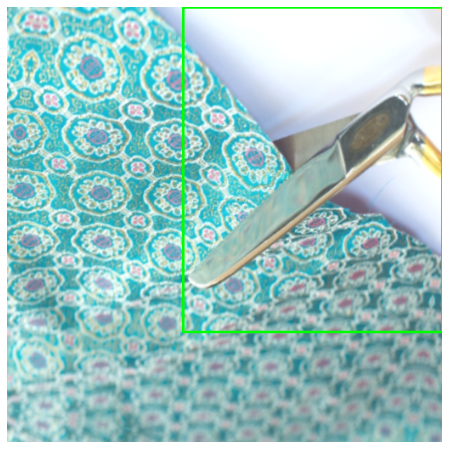

In [9]:
image, target, image_id = train_dataset[k]
k+=1
boxes = target['boxes'].cpu().numpy().astype(np.int32)
labels = target['labels'].cpu().numpy().astype(int)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for i, box in enumerate(boxes):
     cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
     cv2.putText(numpy_image, labelNameDict[labels[i]], (box[1], box[0]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

ax.set_axis_off()
ax.imshow(numpy_image);

In [10]:
class AverageCalculator(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [11]:
class FocalLoss(nn.Module):
    def __init__(self, normalizer, alpha=0.25, gamma=2):
        super().__init__()
        self.normalizer = normalizer
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred_logits, target):
        pred = pred_logits.sigmoid()
        ce = F.binary_cross_entropy_with_logits(pred_logits, target, reduction='none')
        alpha = target * self.alpha + (1. - target) * (1. - self.alpha)
        pt = torch.where(target == 1, pred, 1 - pred)
        return (1 / self.normalizer) * alpha * (1. - pt) ** self.gamma * ce

In [12]:
def calculate_overall_loss(
        cls_outputs,
        box_outputs,
        cls_targets,
        box_targets,
        num_positives,
        num_classes,
        alpha,
        gamma,
        delta,
        box_loss_weight,
        ):

    num_positives_sum = (num_positives.sum() + 1.0).float()
    levels = len(cls_outputs)

    cls_losses = []
    box_losses = []
    for l in range(levels):
        cls_targets_at_level = cls_targets[l]
        box_targets_at_level = box_targets[l]

        cls_targets_at_level_oh = one_hot(cls_targets_at_level, num_classes)

        bs, height, width, _, _ = cls_targets_at_level_oh.shape
        cls_targets_at_level_oh = cls_targets_at_level_oh.view(bs, height, width, -1)
        cls_outputs_at_level = cls_outputs[l].permute(0, 2, 3, 1).float()

        focal_loss = FocalLoss(normalizer=num_positives_sum, alpha=alpha, gamma=gamma)

        cls_loss = focal_loss.forward(cls_outputs_at_level, cls_targets_at_level_oh)

        cls_loss = cls_loss.view(bs, height, width, -1, num_classes)
        cls_loss = cls_loss * (cls_targets_at_level != -2).unsqueeze(-1)
        cls_losses.append(cls_loss.sum())

        box_losses.append(_box_loss(
            box_outputs[l].permute(0, 2, 3, 1).float(),
            box_targets_at_level,
            num_positives_sum,
            delta=delta))

    cls_loss = torch.sum(torch.stack(cls_losses, dim=-1), dim=-1)
    box_loss = torch.sum(torch.stack(box_losses, dim=-1), dim=-1)
    total_loss = cls_loss + box_loss_weight * box_loss
    return total_loss, cls_loss, box_loss


In [13]:
def bb_intersection_over_union(trueBox, predBox):
    xA = max(trueBox[0], predBox[1])
    yA = max(trueBox[1], predBox[0])
    xB = min(trueBox[2], predBox[3])
    yB = min(trueBox[3], predBox[2])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxAArea = (trueBox[2] - trueBox[0] + 1) * (trueBox[3] - trueBox[1] + 1)
    boxBArea = (predBox[3] - predBox[1] + 1) * (predBox[2] - predBox[0] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

def display_prediction(image, true_bbox, pred_bbox):
    shape_true = [(true_bbox[1], true_bbox[0]), (true_bbox[3], true_bbox[2])]
    shape_pred = [(pred_bbox[0], pred_bbox[1]), (pred_bbox[2], pred_bbox[3])]

    image = image.permute(1,2,0).cpu().numpy()
    image = Image.fromarray(np.uint8(image*255))

    img1 = ImageDraw.Draw(image)
    img1.rectangle(shape_true, outline="green", width=5)
    img1.rectangle(shape_pred, outline="red", width=5)
    plt.figure()
    plt.plot(512, 512)
    plt.imshow(image)

def calculate_best_box_accuracy(image, true_box, pred_boxes):
    ious = []
    for i, pred_box in enumerate(pred_boxes):
        box_accuracy = bb_intersection_over_union(true_box, pred_box)
        ious.append(box_accuracy)

    maxIou = max(ious)
    index = ious.index(maxIou)
    #display_prediction(image, true_box, pred_boxes[index])
    return index, maxIou

def calculate_acc(images, target, detections):
    box_accuracy_sum = 0
    cls_accuracy_sum = 0
    count = 0
    for i, tars in enumerate(target['bbox']):
        for j, tar in enumerate(tars):
            det_index, box_accuracy = calculate_best_box_accuracy(images[i], tar, detections[i][:len(tars)])
            box_accuracy_sum += box_accuracy
            if target['cls'][i][j].item() == detections[i][det_index][5]:
                cls_accuracy_sum += 1
            count += 1
    return box_accuracy_sum / count, cls_accuracy_sum / count

In [14]:
def _batch_detection(
        batch_size, class_out, box_out, anchor_boxes, indices, classes,
        img_scale = None,
        img_size = None,
        max_det_per_image = 100,
        soft_nms = False,
):
    batch_detections = []

    for i in range(batch_size):
        img_scale_i = None if img_scale is None else img_scale[i]
        img_size_i = None if img_size is None else img_size[i]
        detections = generate_detections(
            class_out[i], box_out[i], anchor_boxes, indices[i], classes[i],
            img_scale_i, img_size_i, max_det_per_image=max_det_per_image, soft_nms=soft_nms)
        batch_detections.append(detections)
    return torch.stack(batch_detections, dim=0)

class CustomEfficientDet(nn.Module):
    def __init__(self, model):
        super(CustomEfficientDet, self).__init__()
        self.model = model
        self.config = model.config
        self.num_levels = model.config.num_levels
        self.num_classes = model.config.num_classes
        self.anchors = Anchors.from_config(model.config)
        self.max_detection_points = model.config.max_detection_points
        self.max_det_per_image = model.config.max_det_per_image
        self.soft_nms = model.config.soft_nms
        self.anchor_labeler = AnchorLabeler(self.anchors, self.num_classes, match_threshold=0.5)
        self.loss_fn = calculate_overall_loss

    def forward(self, x, target):
        class_out, box_out = self.model(x)

        cls_targets, box_targets, num_positives = self.anchor_labeler.batch_label_anchors(
            target['bbox'], target['cls'])

        loss, class_loss, box_loss = self.loss_fn(
            class_out, box_out, cls_targets, box_targets, num_positives,
            num_classes=self.num_classes, alpha=self.config.alpha, gamma=self.config.gamma, delta=self.config.delta,
            box_loss_weight=self.config.box_loss_weight)
        output = {'loss': loss, 'class_loss': class_loss, 'box_loss': box_loss}

        if not self.training:
            class_out_pp, box_out_pp, indices, classes = _post_process(
                    class_out, box_out, num_levels=self.num_levels, num_classes=self.num_classes,
                    max_detection_points=self.max_detection_points)

            output['detections'] = _batch_detection(
                x.shape[0], class_out_pp, box_out_pp, self.anchors.boxes, indices, classes,
                target['img_scale'], target['img_size'],
                max_det_per_image=self.max_det_per_image, soft_nms=self.soft_nms)

            box_acc, cls_acc = calculate_acc(x, target, output['detections'])
            output['cls_accuracy'] = cls_acc
            output['box_accuracy'] = box_acc

        return output

In [15]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:

    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)

        self.log_path = f'{self.base_dir}/log.txt'
        self.best_avg_loss = 10**5

        self.model = model
        self.device = device

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter is prepared on device: {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            lr = self.optimizer.param_groups[0]['lr']
            timestamp = datetime.utcnow().isoformat()
            self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            loss_avg = self.train_one_epoch(train_loader)

            self.log(f'[TRAINING] Epoch: {self.epoch}, loss: {loss_avg.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/latest-training-big-dataset-D5-fine-tuning.bin')

            t = time.time()
            loss_avg, cls_accuracy_avg, box_accuracy_avg = self.validation(validation_loader)

            self.log(f'[VALIDATION] Epoch: {self.epoch}, loss: {loss_avg.avg:.5f}, box_accuracy: {box_accuracy_avg.avg:.5f}, cls_accuracy: {cls_accuracy_avg.avg:.5f}, time: {(time.time() - t):.5f}')
            if loss_avg.avg < self.best_avg_loss:
                self.best_avg_loss = loss_avg.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=loss_avg.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        loss_avg = AverageCalculator()
        cls_accuracy = AverageCalculator()
        box_accuracy = AverageCalculator()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            print(f'Validating: {step}/{len(val_loader)}, ' + \
                    f'loss: {loss_avg.avg:.5f}, ' + \
                    f'box_accuracy: {box_accuracy.avg:.5f}, ' + \
                    f'cls_accuracy: {cls_accuracy.avg:.5f}')
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                target_res = {}
                target_res['bbox'] = boxes
                target_res['cls'] = labels
                target_res["img_scale"] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(self.device)
                target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(self.device)

                outputs = self.model(images, target_res)
                cls_accuracy_value = outputs['cls_accuracy']
                box_accuracy_value = outputs['box_accuracy']

                loss = outputs['loss']
                loss_avg.update(loss.detach().item(), batch_size)
                cls_accuracy.update(cls_accuracy_value, batch_size)
                box_accuracy.update(box_accuracy_value, batch_size)

        return loss_avg, cls_accuracy, box_accuracy

    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_avg = AverageCalculator()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            print(f'Training: {step}/{len(train_loader)}, ' + \
                    f'loss: {loss_avg.avg:.5f}')
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]

            target_res = {}

            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            target_res['bbox'] = boxes
            target_res['cls'] = labels
            target_res["img_scale"] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(self.device)
            target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(self.device)

            self.optimizer.zero_grad()

            outputs = self.model(images, target_res)

            loss = outputs['loss']

            loss.backward()

            loss_avg.update(loss.detach().item(), batch_size)
            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return loss_avg

    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_avg_loss': self.best_avg_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_avg_loss = checkpoint['best_avg_loss']
        self.epoch = checkpoint['epoch'] + 1

    def log(self, message):
        print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [16]:
class ModelConfiguration:
    batch_size = 3
    n_epochs = 500
    lr = 0.0002

    folder = 'checkpoints'

    step_scheduler = False
    validation_scheduler = True

    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False,
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0,
        min_lr=1e-8,
        eps=1e-08
    )

In [17]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = DataLoader(
        train_dataset,
        batch_size=ModelConfiguration.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        collate_fn=collate_fn,
    )
    val_loader = DataLoader(
        validation_dataset,
        batch_size=ModelConfiguration.batch_size,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )
    fitter = Fitter(model=net, device=device, config=ModelConfiguration)
    fitter.load('checkpoints/latest-training-big-dataset-D5-fine-tuning.bin')
    fitter.fit(train_loader, val_loader)

In [18]:
config = get_efficientdet_config('tf_efficientdet_d5')
config.norm_kwargs = dict(eps=.001, momentum=.01)
config.num_classes = 3
config.max_det_per_image = 15
config.max_detection_points = 15
config.image_size = [512, 512]
net = EfficientDet(config, pretrained_backbone=True)
net.class_net = HeadNet(config, num_outputs=config.num_classes)

net = CustomEfficientDet(net)

In [19]:
run_training()

Fitter is prepared on device: cuda:0

2021-05-03T08:10:57.035529
LR: 1.220703125e-08
Training: 0/837, loss: 0.00000
tensor(109., device='cuda:0')


KeyboardInterrupt: 

In [3]:
TEST_ROOT_PATH = 'data/dataset/EfficientDetDataset/test'

class TestDataRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TEST_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [4]:
def get_test_transforms():
    return A.Compose([
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [24]:
test_dataset = TestDataRetriever(
    image_ids=np.array([path.split('\\')[-1][:-4] for path in glob(f'{TEST_ROOT_PATH}/*.jpg')]),
    transforms=get_test_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn
)

batch:  (tensor([[[0.2044, 0.2078, 0.2078,  ..., 0.1608, 0.1608, 0.1608],
         [0.2070, 0.2078, 0.2078,  ..., 0.1608, 0.1608, 0.1608],
         [0.2078, 0.2087, 0.2101,  ..., 0.1622, 0.1608, 0.1608],
         ...,
         [0.1434, 0.1434, 0.1458,  ..., 0.1484, 0.1495, 0.1501],
         [0.1432, 0.1432, 0.1456,  ..., 0.1539, 0.1558, 0.1569],
         [0.1490, 0.1490, 0.1514,  ..., 0.1569, 0.1569, 0.1569]],

        [[0.1926, 0.1961, 0.1961,  ..., 0.1490, 0.1490, 0.1490],
         [0.1952, 0.1961, 0.1961,  ..., 0.1490, 0.1490, 0.1490],
         [0.1961, 0.1969, 0.1983,  ..., 0.1504, 0.1490, 0.1490],
         ...,
         [0.1748, 0.1748, 0.1772,  ..., 0.1641, 0.1652, 0.1658],
         [0.1755, 0.1755, 0.1780,  ..., 0.1700, 0.1725, 0.1735],
         [0.1843, 0.1843, 0.1867,  ..., 0.1741, 0.1765, 0.1765]],

        [[0.1652, 0.1686, 0.1686,  ..., 0.1294, 0.1294, 0.1294],
         [0.1678, 0.1686, 0.1686,  ..., 0.1294, 0.1294, 0.1294],
         [0.1686, 0.1695, 0.1709,  ..., 0.1308, 0

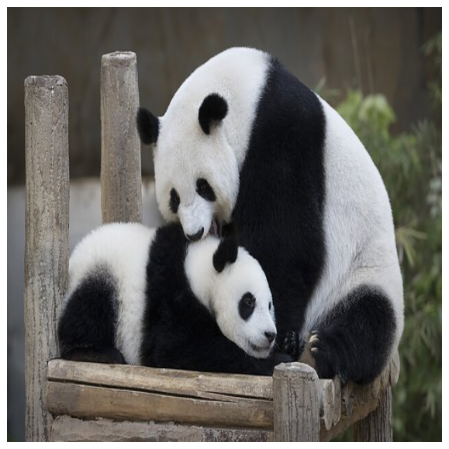

In [25]:
for j, (images, image_ids) in enumerate(data_loader):
  break
print('batch: ', images)
print('collate: ', set(zip(*images)))
i = 0
sample = images[i].permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.set_axis_off()
ax.imshow(sample);

In [26]:
import gc

config = get_efficientdet_config('tf_efficientdet_d5')
config.norm_kwargs = dict(eps=.001, momentum=.01)
config.num_classes = 3
config.image_size = [512, 512]
net = EfficientDet(config, pretrained_backbone=True)
net.class_net = HeadNet(config, num_outputs=config.num_classes)
checkpoint = torch.load('checkpoints/latest-training-big-dataset-D5.bin')
net.load_state_dict(checkpoint['model_state_dict'])

del checkpoint
gc.collect()

net = DetBenchPredict(net)
net.eval();
net = net.cuda()


In [27]:
def make_predictions(images, score_threshold=0.1):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        det = net(images)
        print(det[0][0])
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]
            scores = det[i].detach().cpu().numpy()[:,4]
            labels = det[i].detach().cpu().numpy()[:,5].astype(int)
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            labels = labels[indexes]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
                'labels': labels[indexes]
            })
    return [predictions]

tensor([154.5694,  42.4959, 456.0033, 362.7083,   0.6723,   1.0000],
       device='cuda:0')
tensor([  0.9125,   4.9574, 437.1505, 427.5142,   0.9408,   2.0000],
       device='cuda:0')
tensor([328.3685, 275.6446, 468.2513, 354.7203,   0.8773,   3.0000],
       device='cuda:0')


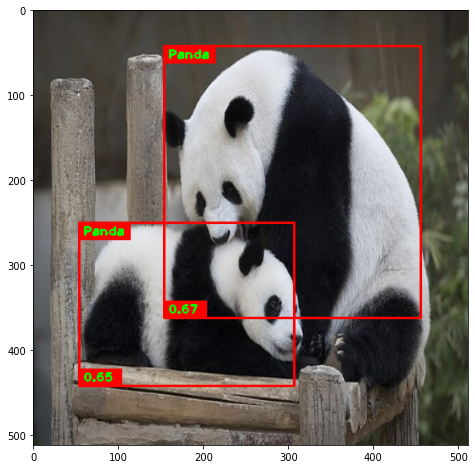

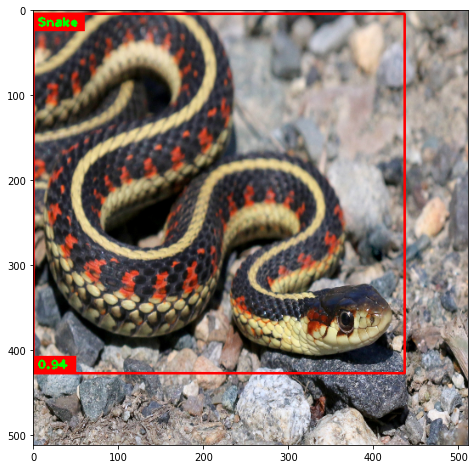

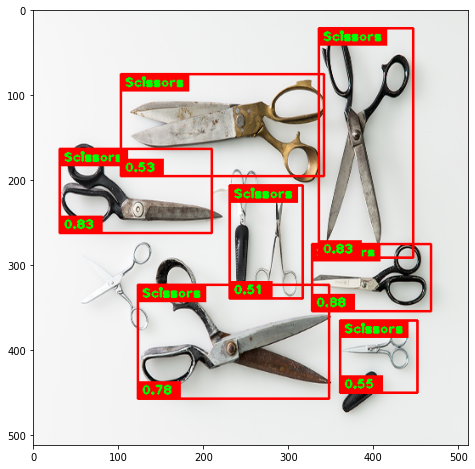

In [28]:
def get_box_size(label):
    if label == 'Scissors':
        return (box[0]+80, box[1]+20)
    else:
        return (box[0]+60, box[1]+20)

for j, (images, image_ids) in enumerate(data_loader):
    predictions = make_predictions(images, 0.5)

    boxes = predictions[0][0]['boxes']
    labels = predictions[0][0]['labels']
    scores = predictions[0][0]['scores']

    sample = images[0].permute(1,2,0).cpu().numpy()

    boxes = boxes.astype(np.int32).clip(min=0, max=511)

    for i, box in enumerate(boxes):
        cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 2)
        cv2.rectangle(sample, (box[0], box[1]), get_box_size(labelNameDict[labels[i]]), (1, 0, 0),-1)
        cv2.putText(sample, labelNameDict[labels[i]], (box[0]+5, box[1] + 15), 1, 1, (0, 1, 0), 2, cv2.LINE_AA)
        cv2.rectangle(sample, (box[0], box[3]), (box[0]+50, box[3]-20), (1, 0, 0),-1)
        cv2.putText(sample, str(round(scores[i], 2)), (box[0]+5, box[3] - 5), 1, 1, (0, 1, 0), 2, cv2.LINE_AA)
    plt.figure(figsize=(8,8))
    plt.imshow(sample);